Gaurav Choudhary

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.optimize import minimize

# 2: Unconditional moments of the ARMA(1,1) model

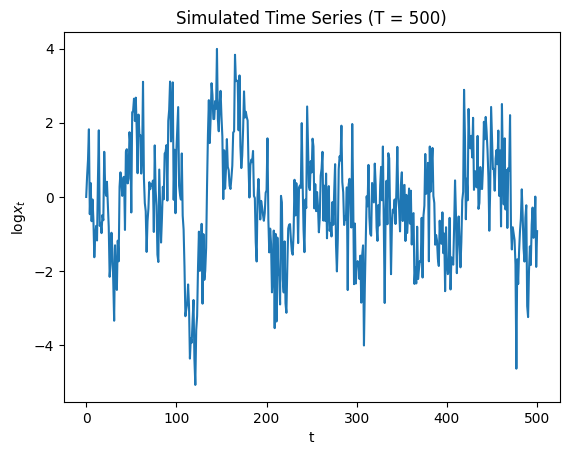

In [2]:
### Part (a): Simulation of 500 observations
np.random.seed(4309)
T = 500
phi = 0.95
theta = -0.6
sigma = 1.0

# Generate T+1 shocks (w0, w1, …, w_T), given that logx_0 = w_0 = 0
w = np.random.randn(T + 1)
w[0] = 0
log_x = np.zeros(T + 1)
log_x[0] = 0.0

# Simulate the series using ARMA(1,1) model
for t in range(1, T + 1):
    log_x[t] = phi * log_x[t - 1] + sigma * w[t] + theta * sigma * w[t - 1]

plt.figure()
plt.plot(log_x)
plt.title('Simulated Time Series (T = 500)')
plt.xlabel('t')
plt.ylabel('log$x_t$')
plt.show()

The time series appears to be very persistent, which is a natural consequence of the parameters we simulated it with.

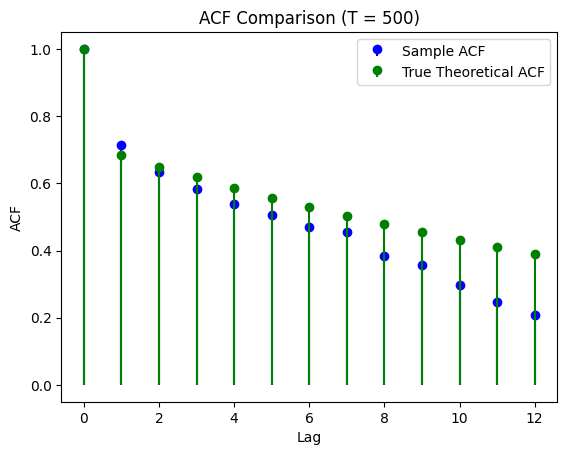

In [3]:
### Part (b): Compute Sample Autocorrelations for lags 1 to 12
sample_acf_truncated = acf(log_x[12:], nlags = 12, fft = False)
lags = np.arange(0, 13)

### Part (c): Compare sample and true theoretical ACFs
# For an ARMA(1,1), Let X = phi + theta. Then,
# acf(1) = [X + phi*X^2/(1-phi^2)] / [1 + X^2/(1-phi^2)] and,
# for lags n > 1, acf(n) = phi * acf(n-1).
X_true = phi + theta   # here 0.95 + (-0.6) = 0.35
acf1_true = (X_true + phi * X_true**2 / (1 - phi**2)) / (1 + X_true**2 / (1 - phi**2))
true_acf = [1.0, acf1_true]  # ACF at lag 0 = 1
for lag in range(2, 13):
    true_acf.append(phi * true_acf[lag - 1])
true_acf = np.array(true_acf)

plt.figure()
plt.stem(lags, sample_acf_truncated, linefmt = 'b-',
         markerfmt = 'bo', basefmt = ' ', label = 'Sample ACF')
plt.stem(lags, true_acf, linefmt = 'g-',
         markerfmt = 'go', basefmt = ' ', label = 'True Theoretical ACF')
plt.title('ACF Comparison (T = 500)')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.legend()
plt.show()

The sample ACFs decay faster than the true theoretical ACFs as the lag size increases.

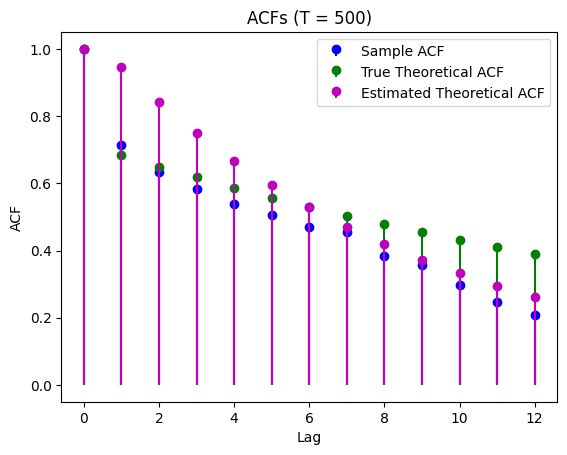


Method-of-Moments estimates (T = 500):
phi_hat = 0.8902215734903678
theta_hat = -0.3905137852752373
sigma_hat = 1.0256397558936845


In [4]:
### Part (d): Method-of-Moments estimation of (sigma, phi, theta)
var_hat = np.var(log_x, ddof = 1)
acf_sample = acf(log_x[12:], nlags = 12, fft = False)
autocorr1_hat = acf_sample[1]
autocorr2_hat = acf_sample[2]

# Define the objective function to minimize squared errors from sample moments
def objective(x):
    sigma, varphi, theta = x

    if abs(varphi) >= 1 or abs(theta) >= 1 or sigma <= 0:
        return np.inf  # ensure stationarity and invertibility, and avoid non-positive sigma

    X = varphi + theta

    try:
        var_model = (sigma**2) * (1 + (X**2 / (1 - varphi**2)))
        autocorr1_model = (X + varphi * X**2 / (1 - varphi**2)) / (1 + X**2 / (1 - varphi**2))
        autocorr2_model = varphi * autocorr1_model
    except ZeroDivisionError:
        return np.inf  # safety check

    return ((var_model - var_hat)**2 +
            (autocorr1_model - autocorr1_hat)**2 +
            (autocorr2_model - autocorr2_hat)**2)

# Initial guess: [sigma, varphi, theta]
initial_guess = [0.5, 0.3, 0.7]

# Bounds to ensure valid parameter space
bounds = [(1e-6, None), (-0.999, 0.999), (-0.999, 0.999)]

# Run optimization
result = minimize(objective, initial_guess, bounds = bounds)
sigma_hat, phi_hat, theta_hat = result.x
X_est = sigma_hat + phi_hat

# Compute the estimated theoretical ACF using estimated parameters
acf1_est = (X_est + phi_hat * X_est**2/(1 - phi_hat**2)) / (1 + X_est**2/(1 - phi_hat**2))
estimated_acf = [1.0, acf1_est]
for lag in range(2, 13):
    estimated_acf.append(phi_hat * estimated_acf[lag - 1])
estimated_acf = np.array(estimated_acf)

plt.figure()
plt.stem(lags, sample_acf_truncated, linefmt = 'b-',
         markerfmt = 'bo', basefmt = ' ', label = 'Sample ACF')
plt.stem(lags, true_acf, linefmt = 'g-',
         markerfmt = 'go', basefmt=' ', label = 'True Theoretical ACF')
plt.stem(lags, estimated_acf, linefmt = 'm-',
         markerfmt = 'mo', basefmt = ' ', label = 'Estimated Theoretical ACF')
plt.title('ACFs (T = 500)')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.legend()
plt.show()

print('\nMethod-of-Moments estimates (T = 500):')
print('phi_hat =', phi_hat)
print('theta_hat =', theta_hat)
print('sigma_hat =', sigma_hat)

The sample ACF and the estimated ACFs are close to each other for the most part, but decay faster than the true theoretical ACF. The MoM estimates are also fairly distant from the true parameter values. The issue arises due to a shorter time-series, something that the next part will be able to fix.

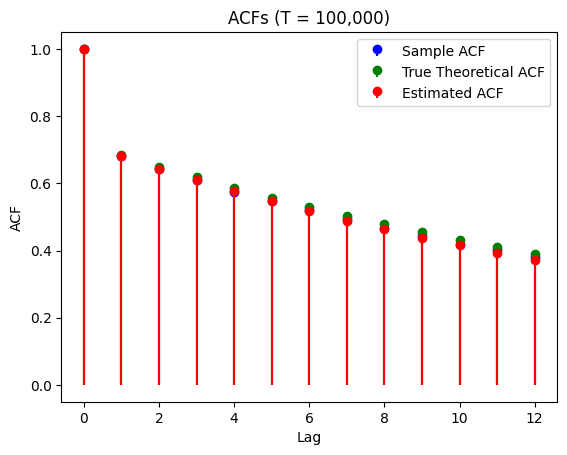


Method-of-Moments estimates (T = 100,000):
phi_hat = 0.9466368791347533
theta_hat = -0.591177756186775
sigma_hat = 1.0004700717693973


In [5]:
### Part (e): Large-sample simulation and re-estimation (T = 100,000)
np.random.seed(4309)
T_large = 100_000
w_large = np.random.randn(T_large + 1)
w_large[0] = 0
log_x_large = np.zeros(T_large + 1)
log_x_large[0] = 0.0

# Simulate ARMA(1,1) process for large T
for t in range(1, T_large + 1):
    log_x_large[t] = phi * log_x_large[t - 1] + sigma * w_large[t] + theta * sigma * w_large[t - 1]

# Compute sample moments from large sample
var_hat_large = np.var(log_x_large, ddof = 1)
acf_large = acf(log_x_large[12:], nlags = 12, fft = True)
autocorr1_hat_large = acf_large[1]
autocorr2_hat_large = acf_large[2]

# Redefine objective for large-sample moments
def objective_large(x):
    sigma, varphi, theta = x

    if abs(varphi) >= 1 or abs(theta) >= 1 or sigma <= 0:
        return np.inf

    X = varphi + theta

    try:
        var_model = (sigma**2) * (1 + (X**2 / (1 - varphi**2)))
        autocorr1_model = (X + varphi * X**2 / (1 - varphi**2)) / (1 + X**2 / (1 - varphi**2))
        autocorr2_model = varphi * autocorr1_model
    except ZeroDivisionError:
        return np.inf

    return ((var_model - var_hat_large)**2 +
            (autocorr1_model - autocorr1_hat_large)**2 +
            (autocorr2_model - autocorr2_hat_large)**2)

# Run optimization again for large sample
result_large = minimize(objective_large, initial_guess, bounds = bounds)
sigma_hat_large, phi_hat_large, theta_hat_large = result_large.x
X_est_large = phi_hat_large + theta_hat_large

# Compute estimated ACFs using large-sample estimates
acf1_est_large = (X_est_large + phi_hat_large * X_est_large**2 / (1 - phi_hat_large**2)) / \
                 (1 + X_est_large**2 / (1 - phi_hat_large**2))
estimated_acf_large = [1.0, acf1_est_large]
for lag in range(2, 13):
    estimated_acf_large.append(phi_hat_large * estimated_acf_large[lag - 1])
estimated_acf_large = np.array(estimated_acf_large)

plt.figure()
plt.stem(lags, acf_large, linefmt = 'b-',
         markerfmt = 'bo', basefmt = ' ', label = 'Sample ACF')
plt.stem(lags, true_acf, linefmt = 'g-',
         markerfmt = 'go', basefmt = ' ', label = 'True Theoretical ACF')
plt.stem(lags, estimated_acf_large, linefmt = 'r-',
         markerfmt = 'ro', basefmt = ' ', label = 'Estimated ACF')
plt.title('ACFs (T = 100,000)')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.legend()
plt.show()

print('\nMethod-of-Moments estimates (T = 100,000):')
print('phi_hat =', phi_hat_large)
print('theta_hat =', theta_hat_large)
print('sigma_hat =', sigma_hat_large)

Given the longer time series, the estimated values line up perfectly with their theoretical counterparts.